In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import statsmodels.formula.api as smf
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt
# from google.colab import drive
# drive.mount('/content/drive')
def tablelize(star):
    string = star.render_latex()
    return string.replace("\\begin{table}[!htbp] \\centering","").replace("\\end{table}","").replace("_","\\_")

<Axes: xlabel='distance', ylabel='Count'>

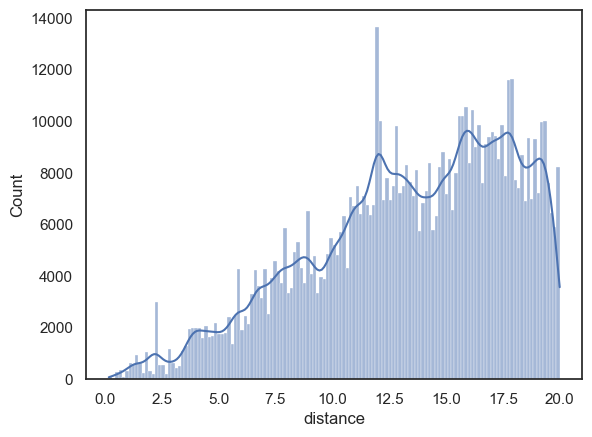

In [3]:
log=np.log
sns.set_theme(style="white")
original_df = pd.read_parquet("../data/ols.parquet")
sns.histplot(original_df["distance"], kde=True)

In [4]:
df = original_df[original_df["保险金额"] > 0].copy()
df["历史投保"] = df["上年保单号"].map(lambda x: 1 if x else 0)
df = df[(df["t"] > 1999) & (df["t"] < 2014)]
df["ti"] = df["t"].astype(str)
df["是否理赔"] = df["total_claim"].map(lambda x: 1 if x > 0 else 0)
df.rename(
    columns={
        "保费合计": "Premium",
        "保险金额": "Coverage",
        "middle": "Neighbor",
        "treated": "Disaster",
        "after": "Post",
        "历史投保": "Prem_before",
        "保险财产购置价": "Price",
        "建筑面积": "Area",
        "是否理赔":"Claim"
    },
    inplace=True,
)
df["Price"]=df["Price"]/1000000
df.head()

,total_claim,下年保单号,Neighbor,区站号,区站经度,区站纬度,保单号,保单经度,保单纬度,distance,...,Coverage,Premium,Price,Area,t,minpost,maxpost,Prem_before,ti,Claim
0,0.0,b'',0,59107,115.15,24.06,b'04FCB0FBCFFC6712E05400144F67CA43',115.257866,24.101398,11.878433,...,220000,195.0,0.0,0.0,2010,165.0,-194.0,0,2010,0
1,0.0,b'',0,59287,113.19,23.08,b'04FCB0FBCFFF6712E05400144F67CA43',113.317337,23.120407,13.776955,...,2400000,2400.0,0.0,0.0,2010,0.0,0.0,0,2010,0
2,0.0,b'',0,59287,113.19,23.08,b'04FCB0FBD0006712E05400144F67CA43',113.317337,23.120407,13.776955,...,3600000,3600.0,0.0,0.0,2010,0.0,0.0,0,2010,0
3,0.0,b'',0,59287,113.19,23.08,b'04FCB0FBD0016712E05400144F67CA43',113.256958,23.116974,7.987591,...,200000,600.0,0.0,0.0,2010,287.0,-238.0,0,2010,0
4,0.0,b'',0,59287,113.19,23.08,b'04FCB0FBD0026712E05400144F67CA43',113.330956,23.137489,15.769465,...,228300,100.0,0.0,0.0,2010,0.0,0.0,0,2010,0


In [96]:
model01 = smf.ols("log(Coverage) ~ Post+Prem_before+Price+Area", data=df).fit()
model01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log(Coverage)   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                 1.657e+04
Date:                Tue, 26 Mar 2024   Prob (F-statistic):               0.00
Time:                        15:48:16   Log-Likelihood:            -7.8618e+05
No. Observations:              522085   AIC:                         1.572e+06
Df Residuals:                  522080   BIC:                         1.572e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.1501      0.004   3390.340      0.000      12.143      12.157
Post            0.0059      0.004      1.500      0.134      -0.002       0.014
Prem_before     0.5074      0.008     65.917      0.000       0.492       0.522
Price           0.1430      0.001    242.794      0.000       0.142       0.144
Area        -1.447e-11   7.82e-11     -0.185      0.853   -1.68e-10    1.39e-10
==============================================================================
Omnibus:                   478812.919   Durbin-Watson:                   0.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        846581941.155
Skew:                          -3.199   Prob(JB):                         0.00
Kurtosis:                     200.170   Cond. No.                     9.85e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.85e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [97]:
model01 = smf.ols("log(Coverage) ~ Post+Prem_before+Price+Area", data=df[df["Price"]>0]).fit()
raws01 = smf.ols("log(Coverage) ~ Post", data=df[df["Price"]>0]).fit()
stargazer = Stargazer([raws01, model01])
stargazer


In [98]:
with open("../lib/table/ols.tex", "w") as f:
    f.write(tablelize(stargazer))

## DID 回归

### 远vs中

In [99]:
model1 = smf.ols("log(Coverage) ~ Neighbor*Post+Prem_before+Price+Area", data=df[(df["Disaster"]==0)]).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log(Coverage)   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                 1.195e+04
Date:                Tue, 26 Mar 2024   Prob (F-statistic):               0.00
Time:                        15:49:49   Log-Likelihood:            -6.7747e+05
No. Observations:              455107   AIC:                         1.355e+06
Df Residuals:                  455100   BIC:                         1.355e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.0666      0.004   2732.715      0.000      12.058      12.075
Neighbor          0.2245      0.012     18.351      0.000       0.200       0.248
Post              0.0676      0.005     14.218      0.000       0.058       0.077
Neighbor:Post     0.0867      0.014      6.320      0.000       0.060       0.114
Prem_before       0.5422      0.008     68.770      0.000       0.527       0.558
Price             0.1532      0.001    245.923      0.000       0.152       0.154
Area          -1.291e-11   7.68e-11     -0.168      0.867   -1.64e-10    1.38e-10
==============================================================================
Omnibus:                   458112.558   Durbin-Watson:                   0.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1087178124.989
Skew:                          -3.771   Prob(JB):                         0.00
Kurtosis:                     242.323   Cond. No.                     2.35e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [101]:
raws1 = smf.ols("log(Coverage) ~ Neighbor*Post", data=df[(df["Disaster"]==0)]).fit()
stargazer = Stargazer([raws1, model1])
stargazer


In [102]:
with open("../lib/table/did1.tex", "w") as f:
    f.write(tablelize(stargazer))

### 远vs近

In [103]:
model2 = smf.ols("log(Coverage) ~ Disaster*Post+Prem_before+Price+Area", data=df[(df["Neighbor"]==0)]).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log(Coverage)   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                 1.051e+04
Date:                Tue, 26 Mar 2024   Prob (F-statistic):               0.00
Time:                        15:50:29   Log-Likelihood:            -7.2554e+05
No. Observations:              480733   AIC:                         1.451e+06
Df Residuals:                  480726   BIC:                         1.451e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.0712      0.005   2678.201      0.000      12.062      12.080
Disaster          0.2070      0.008     25.210      0.000       0.191       0.223
Post              0.0691      0.005     14.243      0.000       0.060       0.079
Disaster:Post    -0.3103      0.010    -31.096      0.000      -0.330      -0.291
Prem_before       0.5471      0.008     67.694      0.000       0.531       0.563
Price             0.1438      0.001    232.713      0.000       0.143       0.145
Area          -1.317e-11   7.84e-11     -0.168      0.867   -1.67e-10    1.41e-10
==============================================================================
Omnibus:                   457127.033   Durbin-Watson:                   0.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        915653689.531
Skew:                          -3.405   Prob(JB):                         0.00
Kurtosis:                     216.697   Cond. No.                     1.65e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [104]:
raws2 = smf.ols("log(Coverage) ~ Disaster*Post", data=df[(df["Neighbor"]==0)]).fit()
stargazer = Stargazer([raws2, model2])
stargazer


In [105]:
with open("../lib/table/did2.tex", "w") as f:
    f.write(tablelize(stargazer))

## 描述性统计

In [24]:
descol=["Coverage","Disaster","Neighbor","Post","Prem_before","Price","Area"]
todesc=df[descol].astype(float).describe()
todesc=todesc.astype(int).astype(str).T.rename(columns={"50%":"median"})
with open("../lib/table/desc.tex", "w") as f:
    print(todesc[['count', 'mean', 'std', 'min', 'median', 'max']].to_latex().replace("_","\\_"), file=f)
with open("../lib/table/corr.tex", "w") as f:
    print(df[descol].corr().to_latex().replace("_","\\_"), file=f)

<Axes: xlabel='Coverage', ylabel='Count'>

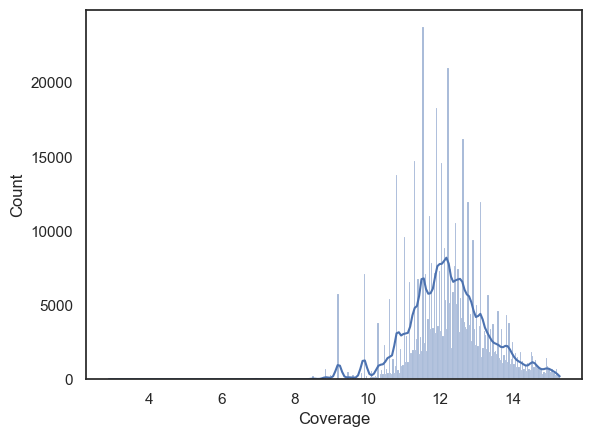

In [15]:
x=0.01
coverage=original_df["保险金额"]
coverage.name="Coverage"
coverage=coverage[coverage.between(coverage.quantile(x)+10,coverage.quantile(1-x))]
coverage=log(coverage)
sns.histplot(coverage,kde=True)

## 进一步分析

In [106]:
df["claimed"]=df["total_claim"].map(lambda x: 1 if x>0 else 0)
claims = smf.logit("claimed ~ log(Coverage)+Disaster*Post+Prem_before+Price", data=df[(df["Neighbor"]==0)]).fit()
rawsclaim = smf.logit("claimed ~ Disaster*Post", data=df[(df["Neighbor"]==0)]).fit()
stargazer = Stargazer([rawsclaim, claims])
# with open("../lib/table/claims.tex", "w") as f:
#     f.write(tablelize(stargazer))
stargazer
# claims.summary()

/Users/dcy/Desktop/thesis/.venv/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.032284
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.035515
         Iterations 9


In [107]:
treated = df[df["Neighbor"]==0].copy()
treated["renew"]=treated["下年保单号"].map(lambda x: 1 if x else 0)
renew = smf.logit("renew ~ log(Coverage)+Disaster*Post+Prem_before+Price", data=treated).fit()
rawsrenew = smf.logit("renew  ~ Disaster*Post", data=treated).fit()
stargazer = Stargazer([rawsclaim,claims,rawsrenew, renew])
stargazer.custom_columns(['Claim', 'Claim', "Renew", "Renew"])
with open("../lib/table/renew.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer
# claims.summary()

Optimization terminated successfully.
         Current function value: 0.116458
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.154195
         Iterations 9


## 稳健性测试

In [26]:
def robust_test(category="Disaster", cond=False):
    df["treated"]=df[category]
    df["Quarter_before"] = df["maxpost"].map(
        lambda x: x // 90  if (x < 0 and x > -365) else None
    )
    df["Quarter_after"] = df["minpost"].map(
        lambda x: x // 90 if (x > 0 and x < 365) else None
    )
    if category == "Disaster":
        df["Quarter_before"] = df["Quarter_after"].fillna(
            (
                pd.to_datetime(df["maxraining_after"])
                - pd.to_datetime(df["保险起期"], unit="s")
            ).dt.days.map(lambda x: x // 90 if (x <= 365 and x >= 0) else None)
        )
        df["Quarter_after"] = df["Quarter_before"].fillna(
            -(
                pd.to_datetime(df["保险起期"], unit="s")
                - pd.to_datetime(df["maxraining_before"])
            ).dt.days.map(lambda x: x // 90  if (x <= 365 and x > 0) else None)
        )
    df["Quarter"] = df["Quarter_before"].fillna(df["Quarter_after"])
    y = -4 if category == "Disaster" else -3
    data = df[df["Quarter"].between(y, 0)].copy()
    reg_str = "log(Coverage) ~ treated*C(Quarter)"
    if cond:
        reg_str += "+Prem_before+Price+Area"
    model = smf.ols(
        reg_str,
        data=data,
    ).fit()
    return model


stargazer = Stargazer(
    [robust_test(i, j) for i in ["Disaster", "Neighbor"] for j in [False, True]]
)
stargazer.custom_columns(["Disaster", "Disaster", "Neighbor", "Neighbor"])
with open("../lib/table/robust.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer

In [29]:
def robust_test(column):
    to_star = []
    data = df[df[column] > 10]
    upper, lower = data[column].quantile(0.99), data[column].quantile(0.01)
    data = data[data[column].between(lower,upper)].copy()
    for var in ["Disaster","Neighbor"]:
        novar = "Neighbor" if var == "Disaster" else "Disaster"
        reg_str = f"log({column}) ~ {var}*Post"
        model = smf.ols(reg_str,data=data[data[novar]==0]).fit()
        to_star.append(model)
        reg_str += "+Prem_before+Price+Area"
        model = smf.ols(reg_str,data=data[data[novar]==0]).fit()
        to_star.append(model)
    stargazer = Stargazer(to_star)
    stargazer.custom_columns(["Disaster", "Disaster", "Neighbor", "Neighbor"])
    return stargazer
premium = robust_test("Premium")
# with open("../lib/table/Premium.tex", "w") as f:
#     f.write(tablelize(premium))
premium